In [1]:
import wfdb
import numpy as np
import os
import csv

In [2]:
def downsample_by_averaging(signal, factor):
    downsampled_signal = []
    
    for i in range(0, len(signal), factor): # moves by index of 8
        chunk = signal[i:i+factor, :] 
        downsampled_signal.append(np.mean(chunk, axis=0))  # avg of each column
        
    return np.array(downsampled_signal)


In [3]:
data_list=[] #takes all the subjects 
directory="non-eeg-dataset-for-assessment-of-neurological-status-1.0.0" # directory to all the files ATR, DAT, HEA
csv_path = os.path.join(directory, 'subjectinfo.csv') 
for i in range(1,21):
    ACCTEMPEDA_Path = os.path.join(directory, f'Subject{i}_AccTempEDA') 
    SPO2HR_Path = os.path.join(directory, f'Subject{i}_SpO2HR') 

    ACCTEMPEDA_Record = wfdb.rdrecord(ACCTEMPEDA_Path) #  rdrecord read .dat and .hea file
    SPO2HR_Record = wfdb.rdrecord(SPO2HR_Path) 
    annotations = wfdb.rdann(ACCTEMPEDA_Path, 'atr') # rdann reads .atr file

    ACCTEMPEDA_DownSampled = downsample_by_averaging(ACCTEMPEDA_Record.p_signal, 8) # downsample ACCTEMP EDA as it is 8 HZ
    ACCTEMPEDA_DownSampled_Record = wfdb.Record(
        record_name=f'Subject{i}_AccTempEDA_DownSampled', 
        p_signal=ACCTEMPEDA_DownSampled, 
        fs=1,
        sig_name=ACCTEMPEDA_Record.sig_name,
        units=ACCTEMPEDA_Record.units        
    )
    with open(csv_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if int(row['subject']) == i:
                data_list.append({
                    'subject_id': i,
                    'acc_temp_eda': ACCTEMPEDA_DownSampled_Record,
                    'spo2_hr': SPO2HR_Record,
                    'annotations': annotations,
                    'age': int(row['age']),
                    'gender': row['gender'],
                    'height_cm': int(row['height/cm']),
                    'weight_kg': int(row['weight/kg'])
                })
                print(f"Subject {i} Metadata:")
                print(f"  Age: {int(row['age'])}")
                print(f"  Gender: {row['gender']}")
                print(f"  Height (cm): {int(row['height/cm'])}")
                print(f"  Weight (kg): {int(row['weight/kg'])}")
                print()

Subject 1 Metadata:
  Age: 30
  Gender: M
  Height (cm): 177
  Weight (kg): 94

Subject 2 Metadata:
  Age: 28
  Gender: M
  Height (cm): 172
  Weight (kg): 68

Subject 3 Metadata:
  Age: 28
  Gender: M
  Height (cm): 177
  Weight (kg): 91

Subject 4 Metadata:
  Age: 22
  Gender: M
  Height (cm): 167
  Weight (kg): 58

Subject 5 Metadata:
  Age: 30
  Gender: M
  Height (cm): 182
  Weight (kg): 82

Subject 6 Metadata:
  Age: 30
  Gender: F
  Height (cm): 167
  Weight (kg): 58

Subject 7 Metadata:
  Age: 33
  Gender: F
  Height (cm): 157
  Weight (kg): 90

Subject 8 Metadata:
  Age: 27
  Gender: M
  Height (cm): 182
  Weight (kg): 64

Subject 9 Metadata:
  Age: 25
  Gender: M
  Height (cm): 177
  Weight (kg): 68

Subject 10 Metadata:
  Age: 23
  Gender: M
  Height (cm): 180
  Weight (kg): 64

Subject 11 Metadata:
  Age: 26
  Gender: M
  Height (cm): 170
  Weight (kg): 71

Subject 12 Metadata:
  Age: 32
  Gender: F
  Height (cm): 162
  Weight (kg): 53

Subject 13 Metadata:
  Age: 29
  Gend

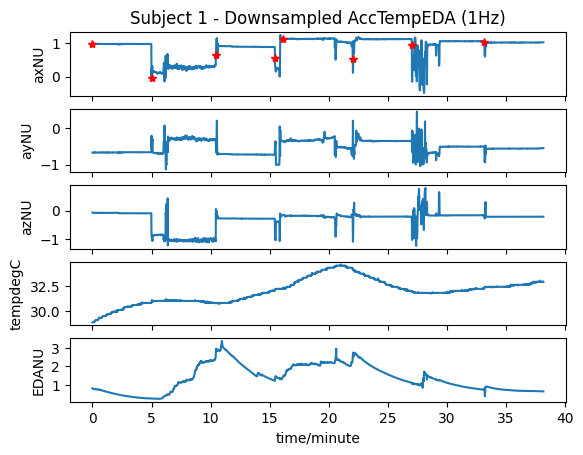

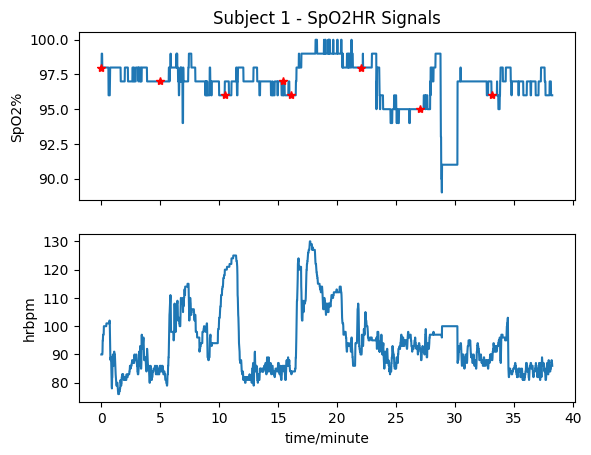

In [4]:
subject = data_list[1]  
wfdb.plot_wfdb( record=subject['acc_temp_eda'], annotation=subject['annotations'], time_units='minutes', title='Subject 1 - Downsampled AccTempEDA (1Hz)')
wfdb.plot_wfdb( record=subject['spo2_hr'], annotation=subject['annotations'], time_units='minutes', title='Subject 1 - SpO2HR Signals')